In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [7]:
import matplotlib as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# COVID-19 CASE DATA

In [68]:
cases = pd.read_csv("data/us-states.csv")
cases['date'] = cases['date'].astype('datetime64[ns]') 
cases = cases.drop(["fips"], axis=1)
cases = cases.dropna()
cases

,date,state,cases,deaths
0,2020-01-21,Washington,1,0
1,2020-01-22,Washington,1,0
2,2020-01-23,Washington,1,0
3,2020-01-24,Illinois,1,0
4,2020-01-24,Washington,1,0
...,...,...,...,...
7489,2020-07-16,Virginia,74431,2007
7490,2020-07-16,Washington,46268,1492
7491,2020-07-16,West Virginia,4657,99
7492,2020-07-16,Wisconsin,43361,839


# MOBILITY DATA

In [10]:
mob = pd.read_csv("data/Global_Mobility_Report.csv", names=['country_region_code', 'country', 'state', 'sub_region_2','iso_3166_2_code',
                                                            'census_fips_code', 'date', 'retail_recreation', 'grocery_pharmacy', 'parks',
                                                            'transit', 'workplaces', 'residential'], low_memory=False)
mobility = mob.loc[mob['country'] == 'United States']
mobility = mobility.drop(['country_region_code', 'census_fips_code', 'iso_3166_2_code', 'country', 'sub_region_2'], axis=1)
mobility = mobility.dropna()
mobility['date'] = mobility['date'].astype('datetime64[ns]') 
mobility = mobility.reset_index().drop(['index'], axis=1)
mobility.describe()

,state,date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential
count,78759,78759,78759,78759,78759,78759,78759,78759
unique,51,156,149,139,526,192,111,45
top,California,2020-02-21 00:00:00,4,1,6,2,2,0
freq,5833,604,1378,2888,826,1434,3137,5178
first,NaN,2020-02-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-07-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


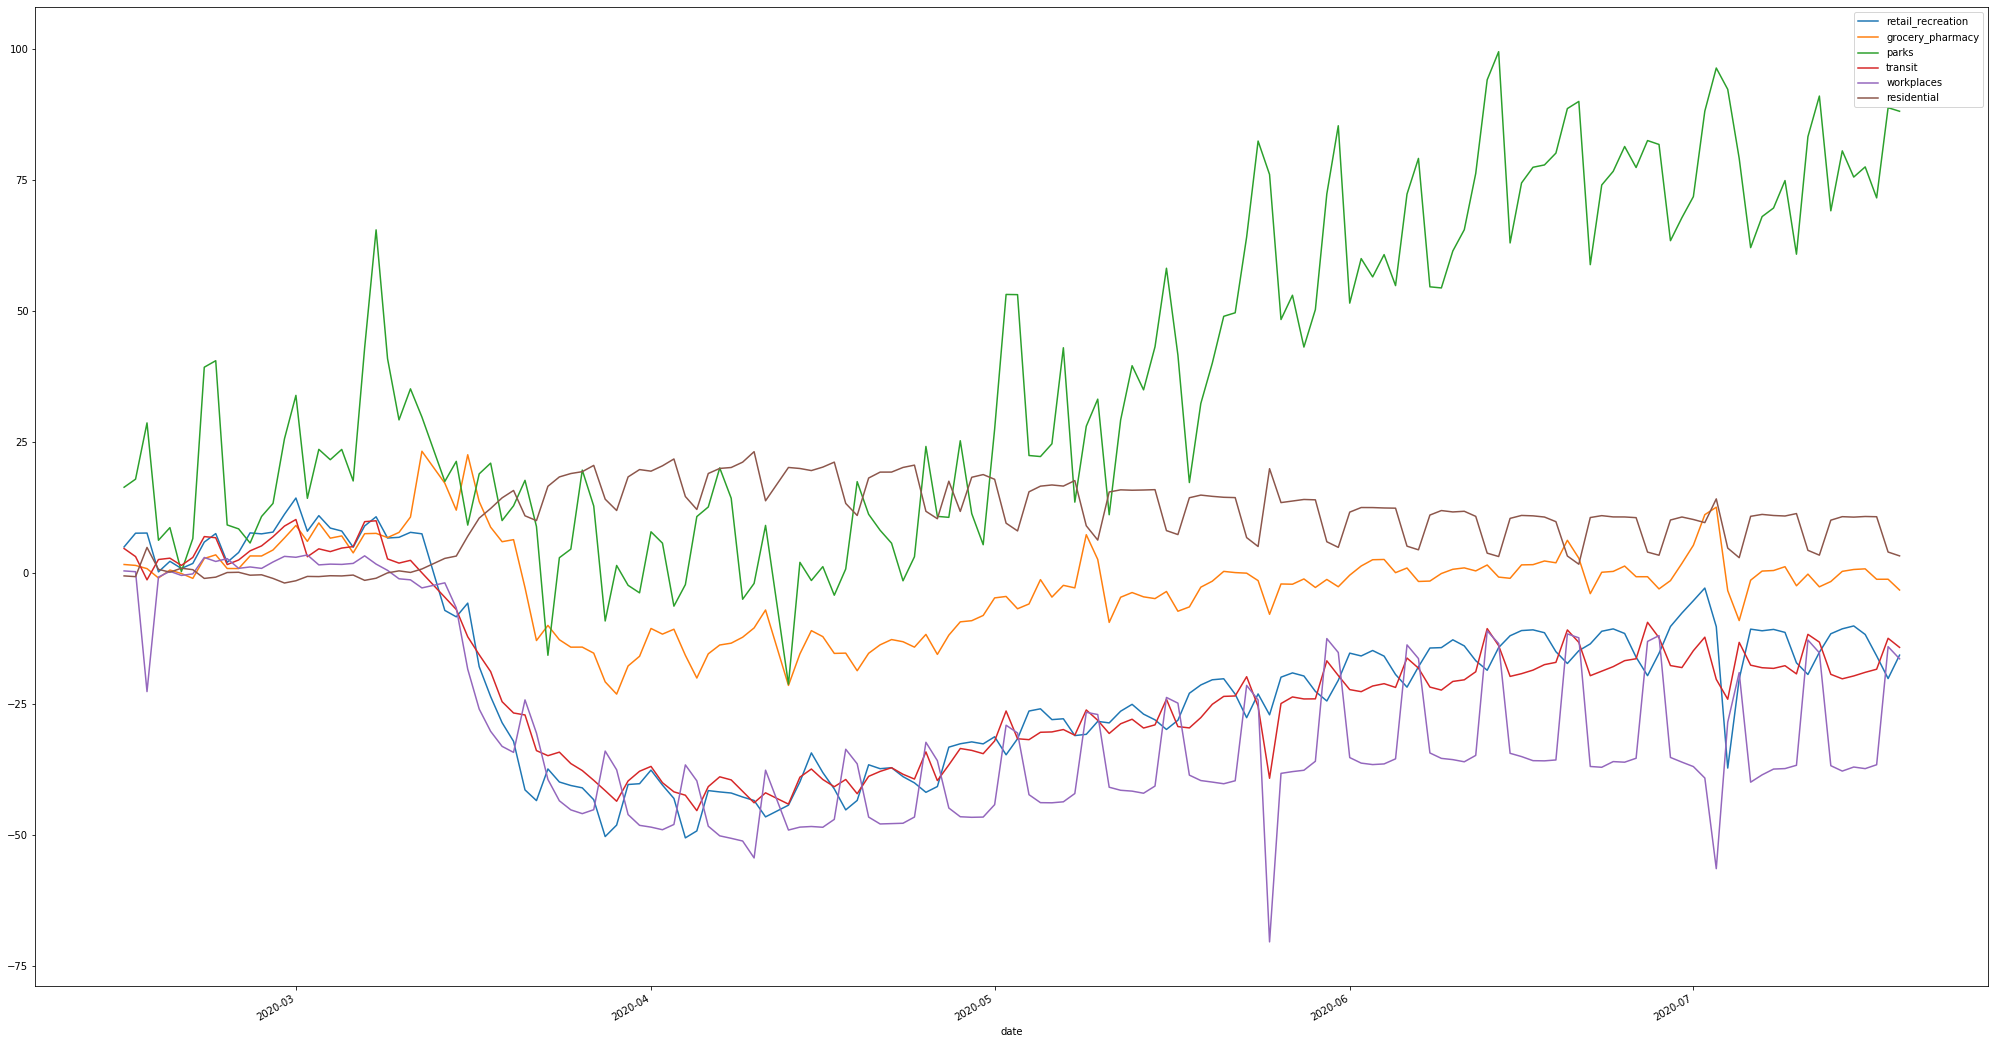

In [11]:
# Visualize the mobility data over time
mob_date = mobility.sort_index(level=['date'])
mob_date['retail_recreation'] = mob_date['retail_recreation'].astype('double') 
mob_date['grocery_pharmacy'] = mob_date['grocery_pharmacy'].astype('double') 
mob_date['parks'] = mob_date['parks'].astype('double') 
mob_date['transit'] = mob_date['transit'].astype('double') 
mob_date['workplaces'] = mob_date['workplaces'].astype('double') 
mob_date['residential'] = mob_date['residential'].astype('double') 
mob_date = mob_date.groupby(['date']).mean()
# Remove any outliers
z_scores = zscore(mob_date)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
mob_date = mob_date[filtered_entries]
# Plot the overall change in mobility over time
mob_date.plot(figsize=(35,20))

# RESTAURANT DATA

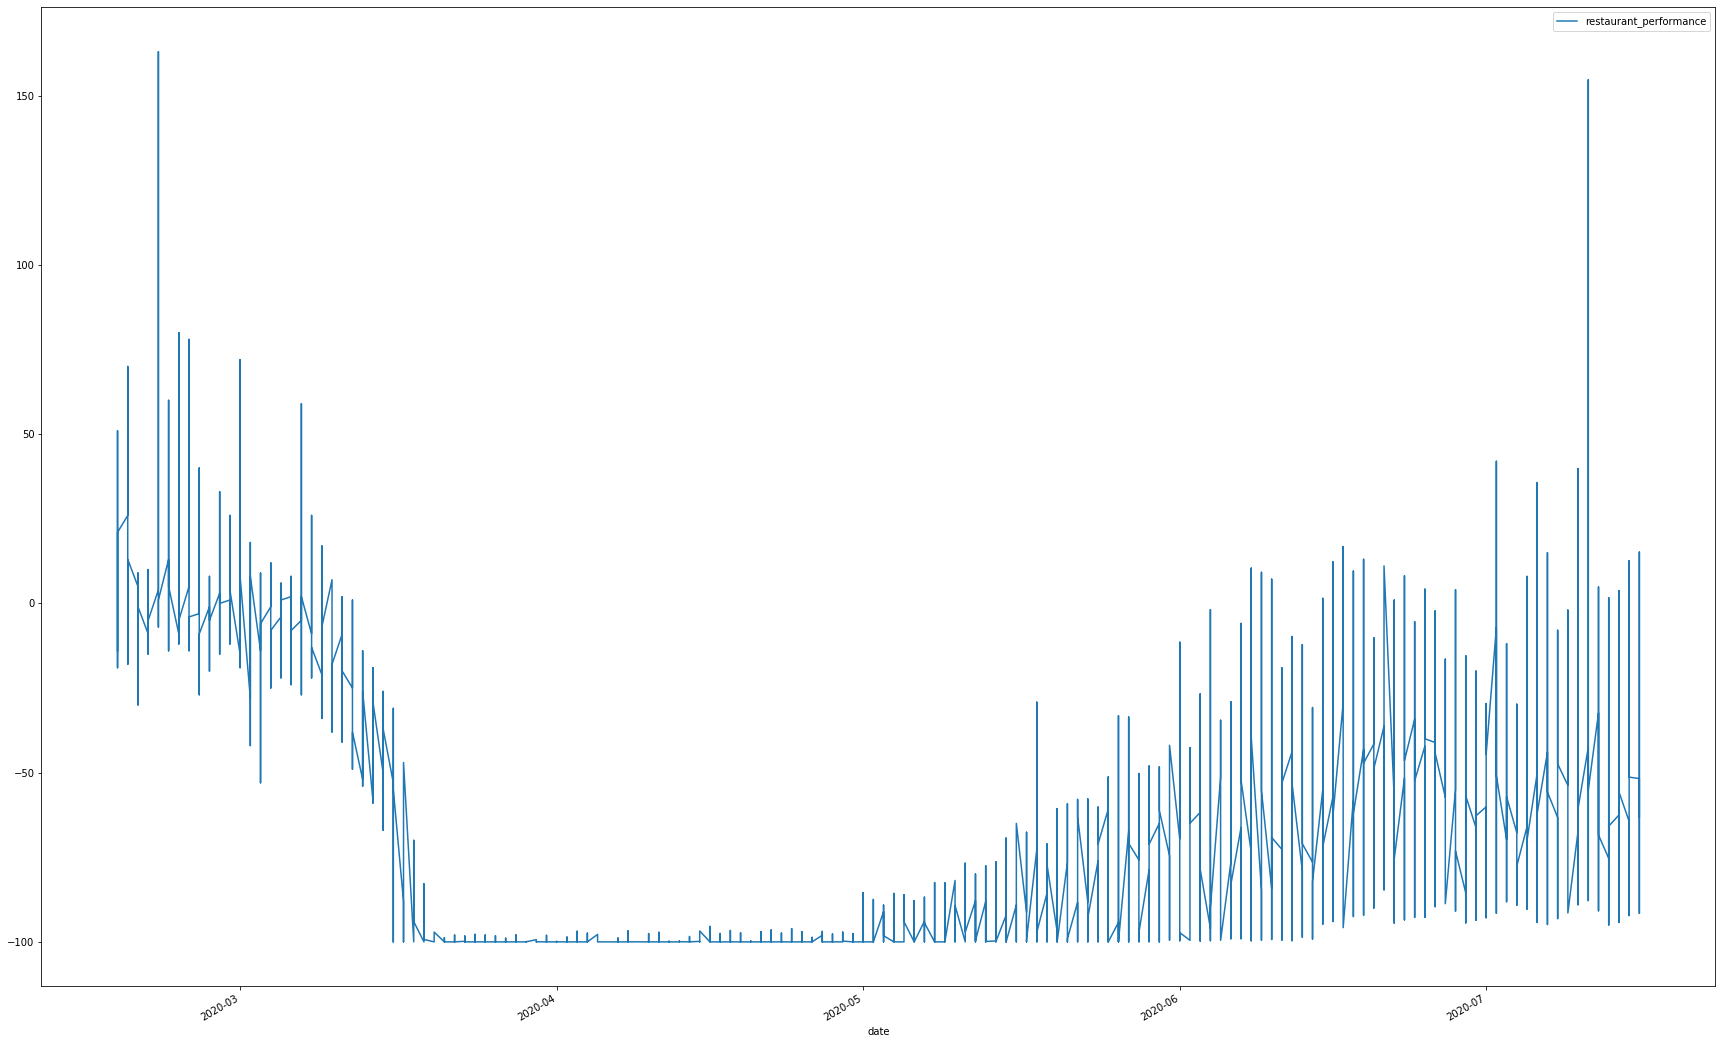

In [69]:
# Restaurant data
rest = pd.read_csv("data/YoY_Seated_Diner_Data.csv")
restaurants = rest[8:57]
restaurants = restaurants.drop([11, 12, 28, 36, 45, 46, 47, 39, 42, 9, 22, 53])
restaurants = restaurants.reset_index().drop(['index', 'Type'], axis=1)
restaurants = restaurants.melt(id_vars=["Name"], var_name="date", value_name="restaurant_performance")
restaurants = restaurants.sort_values(['Name', 'date'], ascending=[True, True])
def add_year(date_in_some_format):
    date_as_string = str(date_in_some_format)
    new_date = date_as_string + '/2020'
    return new_date
restaurants['date'] = restaurants['date'].apply(add_year)
restaurants['date'] = restaurants['date'].astype('datetime64[ns]') 
restaurants = restaurants.rename({'Name':'state'}, axis='columns')
restaurants.plot(x='date', y='restaurant_performance', figsize=(30,20))

In [13]:
restaurants.describe()

,restaurant_performance
count,5550.000000
mean,-68.545553
std,36.498080
min,-100.000000
25%,-100.000000
50%,-81.080000
75%,-49.007500
max,163.000000


# Combine All Data

In [70]:
# Merge the movbility, case and restaurant data
all_data = pd.merge(mobility, cases, on=["state", "date"], how="left")
all_data = all_data.dropna()
all_data = pd.merge(all_data, restaurants, on=["state", "date"], how="left")
all_data = all_data.dropna()
all_data = all_data.reset_index().drop(['index'], axis=1)
all_data['date'] = all_data['date'].astype('datetime64[ns]') 

all_data['retail_recreation'] = all_data['retail_recreation'].astype('int') 
all_data['grocery_pharmacy'] = all_data['grocery_pharmacy'].astype('int') 
all_data['parks'] = all_data['parks'].astype('int') 
all_data['transit'] = all_data['transit'].astype('int') 
all_data['workplaces'] = all_data['workplaces'].astype('int') 
all_data['residential'] = all_data['residential'].astype('int') 

all_data_new = all_data.copy()

# Print
all_data

,state,date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,cases,deaths,restaurant_performance
0,Alabama,2020-03-13,7,32,26,7,-2,0,6.0,0.0,-24.00
1,Alabama,2020-03-14,1,28,55,12,4,0,12.0,0.0,-28.00
2,Alabama,2020-03-15,-7,16,16,6,-4,2,23.0,0.0,-38.00
3,Alabama,2020-03-16,-2,24,22,2,-10,4,29.0,0.0,-57.00
4,Alabama,2020-03-17,-11,17,25,-1,-17,7,39.0,0.0,-74.00
...,...,...,...,...,...,...,...,...,...,...,...
62774,Wisconsin,2020-06-29,-7,-5,112,8,-31,9,31103.0,786.0,-67.14
62775,Wisconsin,2020-07-03,-5,5,194,25,-57,11,33565.0,804.0,-49.03
62776,Wisconsin,2020-07-07,-7,-6,123,24,-33,10,35834.0,817.0,-58.37
62777,Wisconsin,2020-07-09,-6,-3,103,38,-31,10,37358.0,821.0,-63.04


# Plot all data

In [103]:
all_normalized = all_data.copy()

all_normalized['cases_diff'] = (all_normalized.groupby('date')['cases'].apply(pd.Series.pct_change))

# Normalize the values

scaler = preprocessing.StandardScaler()
all_normalized[['cases', 'deaths', 'restaurant_performance', 'retail_recreation', 'grocery_pharmacy', 'parks', 'transit', 'workplaces', 'residential', 'cases', 'deaths', 'restaurant_performance']] = scaler.fit_transform(all_normalized[['cases', 'deaths', 'restaurant_performance', 'retail_recreation', 'grocery_pharmacy', 'parks', 'transit', 'workplaces', 'residential', 'cases', 'deaths', 'restaurant_performance']])

#drop Nan values
all_normalized = all_normalized.replace([np.inf, -np.inf], np.nan)
all_normalized = all_normalized.dropna()

all_normalized = all_normalized.groupby(['date']).mean()
#all_normalized = all_normalized.loc[all_normalized['cases'] > -0.5]
all_normalized

,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,cases,deaths,restaurant_performance,cases_diff
date,,,,,,,,,,
2020-02-18,1.271304,0.275900,-0.292852,1.171037,1.834041,-1.551196,-0.623511,-0.466754,2.503520,0.086108
2020-02-19,1.287459,0.283529,-0.349446,1.127581,1.882137,-1.561554,-0.623510,-0.466754,2.566809,0.085519
2020-02-20,1.322334,0.316213,-0.364786,1.127860,1.852782,-1.543283,-0.623506,-0.466754,2.554357,0.098848
2020-02-21,1.336313,0.269110,-0.319000,1.182804,1.897352,-1.602451,-0.623497,-0.466754,2.459407,0.101562
2020-02-22,1.475142,0.449541,-0.079991,1.200037,2.007753,-1.700111,-0.623496,-0.466754,2.658144,0.109542
...,...,...,...,...,...,...,...,...,...,...
2020-07-12,0.389697,0.016912,0.811140,0.412028,0.999417,-1.106531,1.240467,0.543493,0.613893,0.500872
2020-07-13,0.578571,0.111053,0.482583,0.165404,-0.237377,-0.217378,1.308120,0.551123,0.370128,0.479233
2020-07-14,0.622090,0.248769,0.658062,0.123671,-0.299346,-0.124033,1.337569,0.552362,0.422735,0.486798


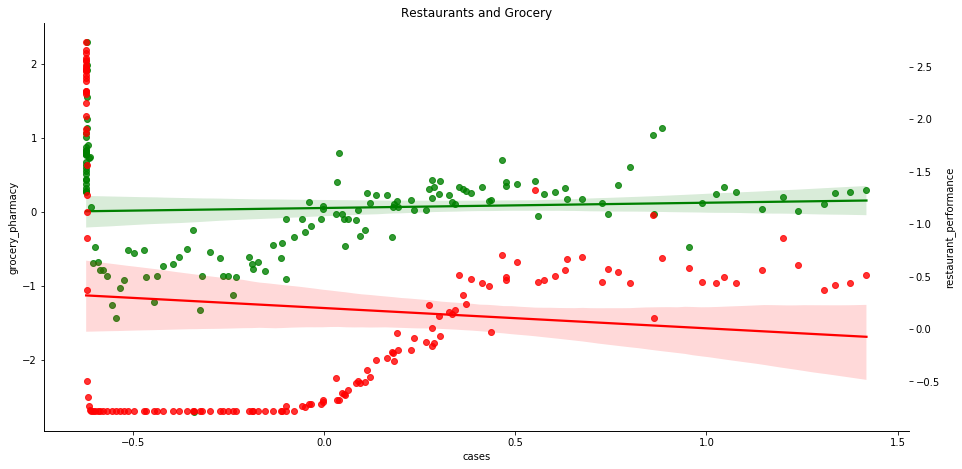

In [148]:
# Plot the relationship between number of cases and restaurant performance and grocery/pharmacy mobility
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)
sns.regplot(all_normalized['cases'], all_normalized['grocery_pharmacy'], ax=ax, color='g')
ax2 = ax.twinx()
sns.regplot(all_normalized['cases'], all_normalized['restaurant_performance'], ax=ax2, color='r').set_title('Restaurants and Grocery')
sns.despine()

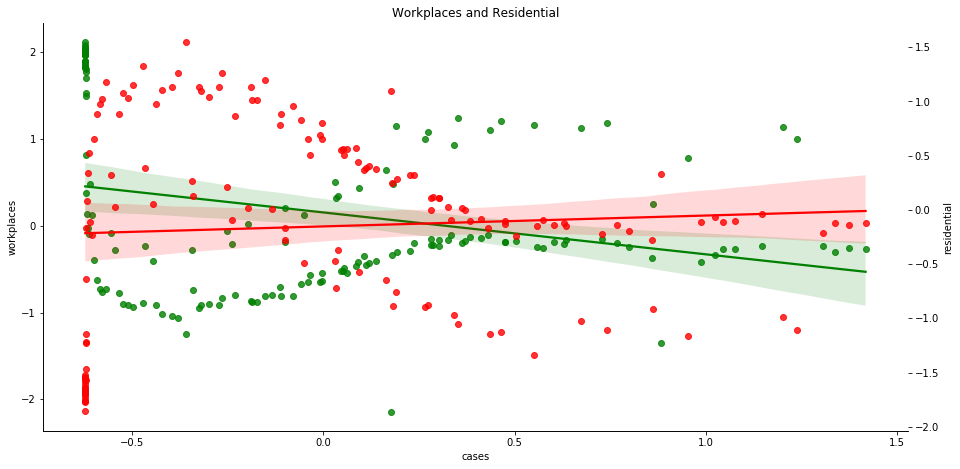

In [145]:
# Plot the relationship between number of cases and workplaces and residential mobility
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)
sns.regplot(all_normalized['cases'], all_normalized['workplaces'], ax=ax, color='g')
ax2 = ax.twinx()
sns.regplot(all_normalized['cases'], all_normalized['residential'], ax=ax2, color='r').set_title('Workplaces and Residential')
sns.despine()

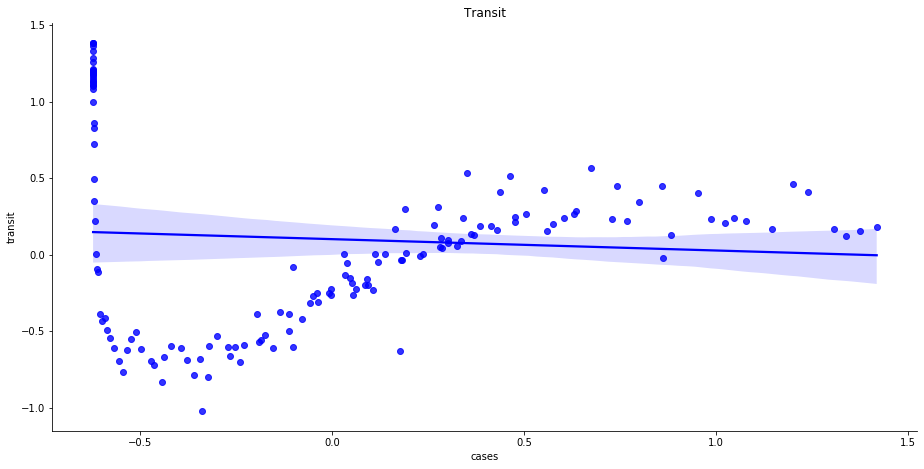

In [146]:
# Plot the relationship between number of cases and transit mobility
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)
sns.regplot(all_normalized['cases'], all_normalized['transit'], ax=ax, color='b').set_title('Transit')
sns.despine()

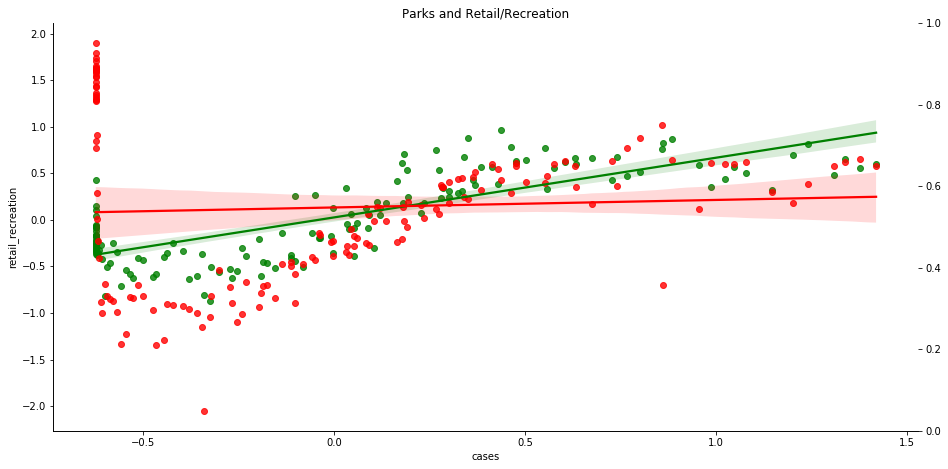

In [147]:
# Plot the relationship between number of cases and parks and retail/recreation mobility
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)
sns.regplot(all_normalized['cases'], all_normalized['parks'], ax=ax, color='g')
ax2 = ax.twinx()
sns.regplot(all_normalized['cases'], all_normalized['retail_recreation'], ax=ax, color='r').set_title('Parks and Retail/Recreation')
sns.despine()

# Number of cases and mobility trends over time

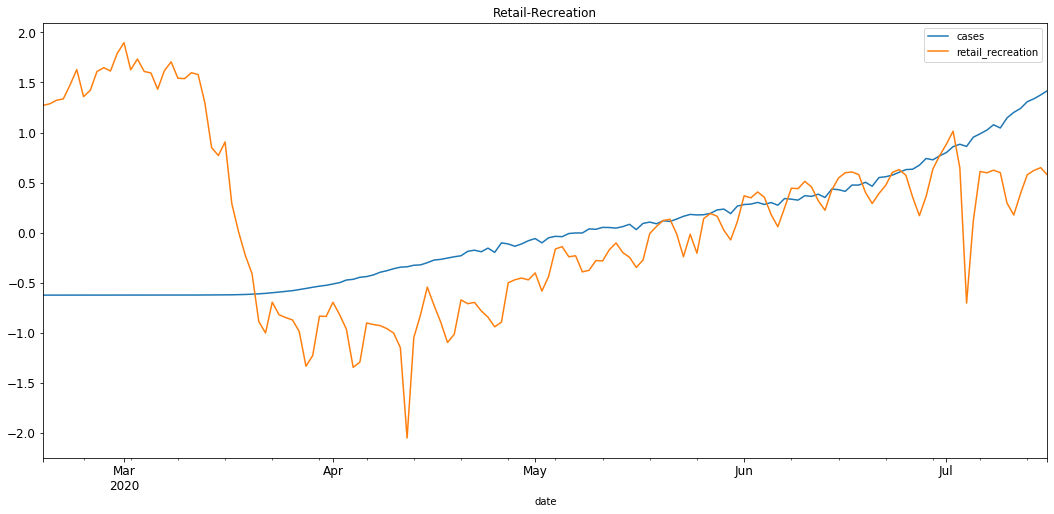

In [138]:
all_normalized.reset_index().plot(x='date', y=['cases', 'retail_recreation'], figsize=(18,8), fontsize=12, title="Retail-Recreation")

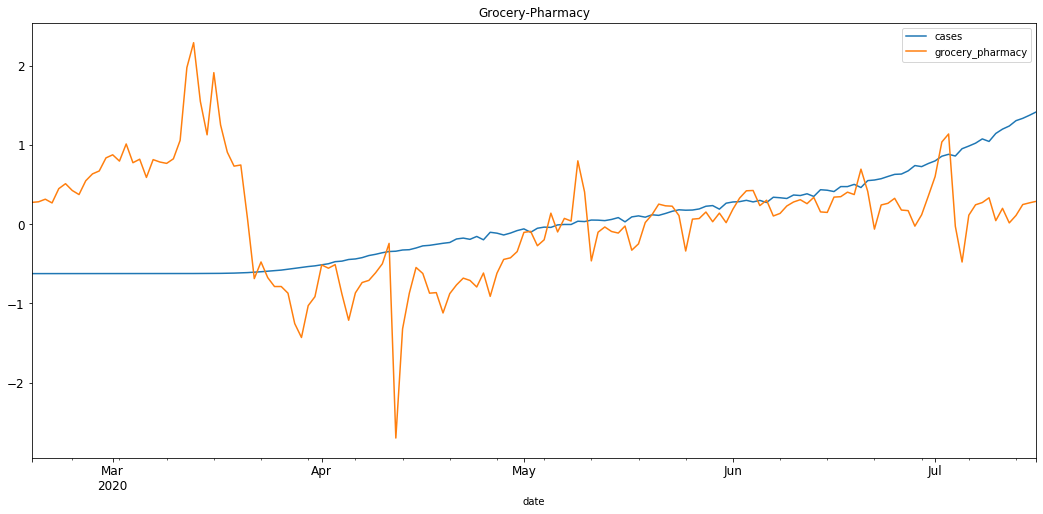

In [139]:
all_normalized.reset_index().plot(x='date', y=['cases', 'grocery_pharmacy'], figsize=(18,8), fontsize=12, title="Grocery-Pharmacy")

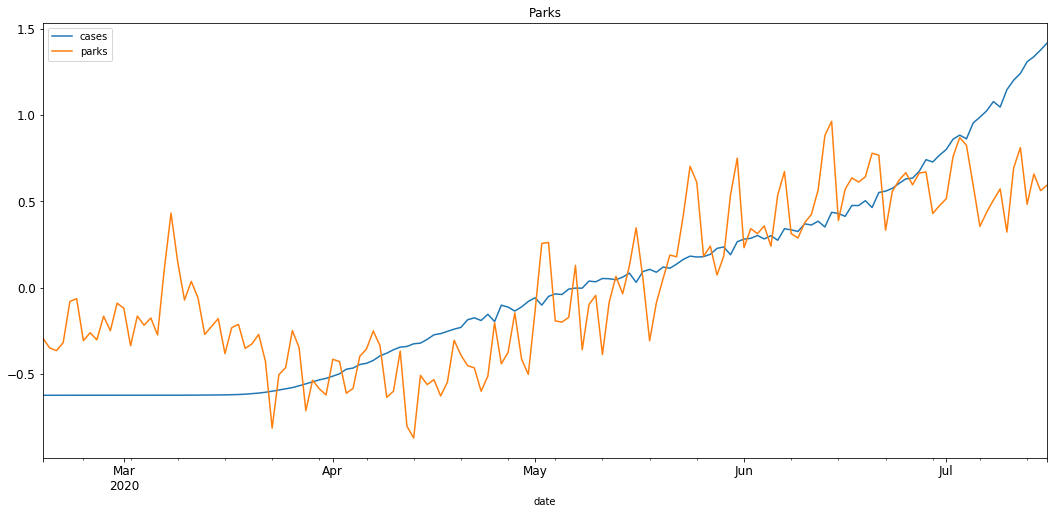

In [140]:
all_normalized.reset_index().plot(x='date', y=['cases', 'parks'], figsize=(18,8), fontsize=12, title="Parks")

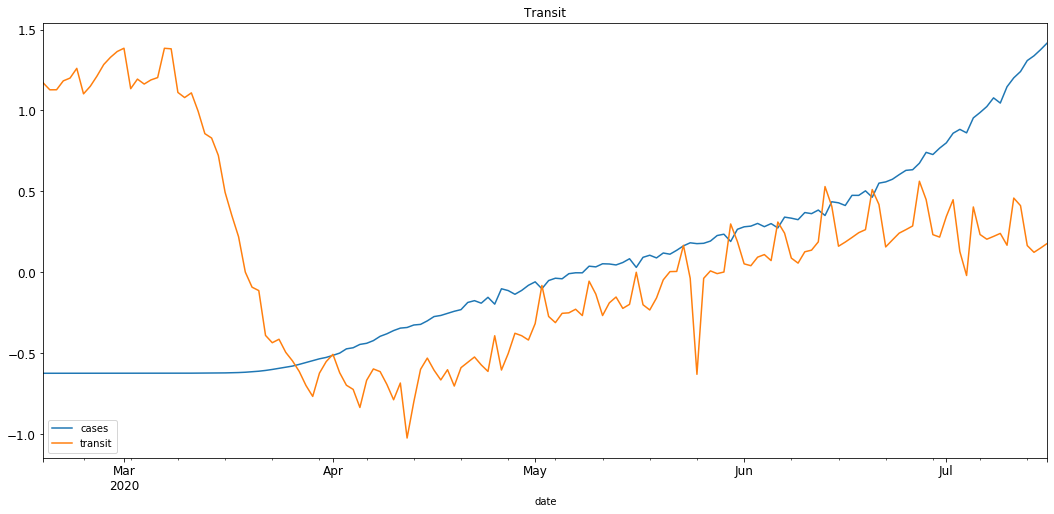

In [141]:
all_normalized.reset_index().plot(x='date', y=['cases', 'transit'], figsize=(18,8), fontsize=12, title="Transit")

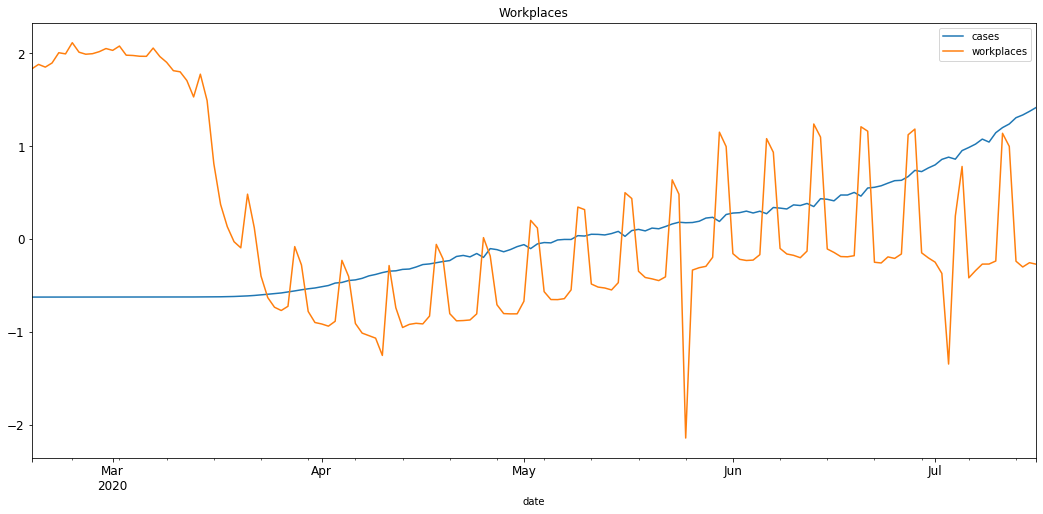

In [142]:
all_normalized.reset_index().plot(x='date', y=['cases', 'workplaces'], figsize=(18,8), fontsize=12, title="Workplaces")

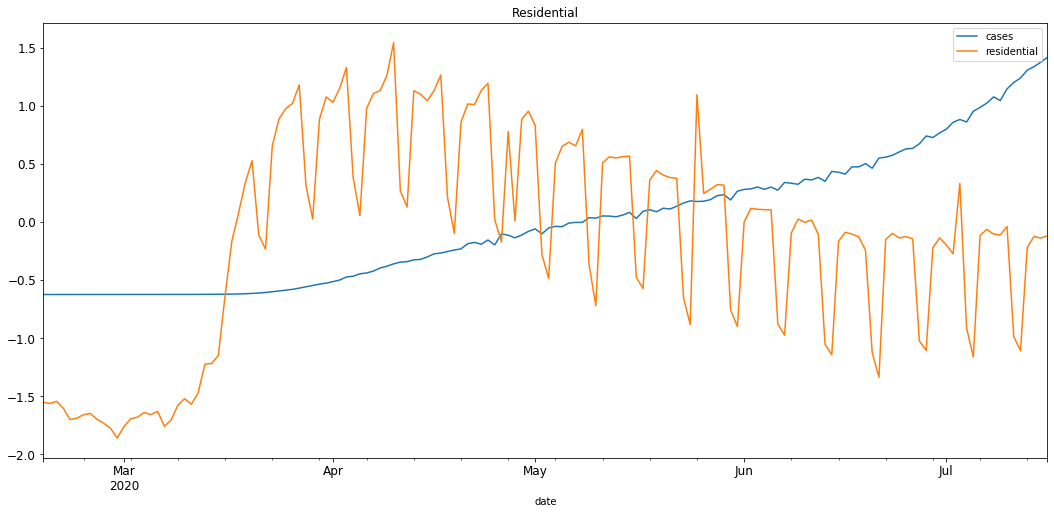

In [143]:
all_normalized.reset_index().plot(x='date', y=['cases', 'residential'], figsize=(18,8), fontsize=12, title="Residential")

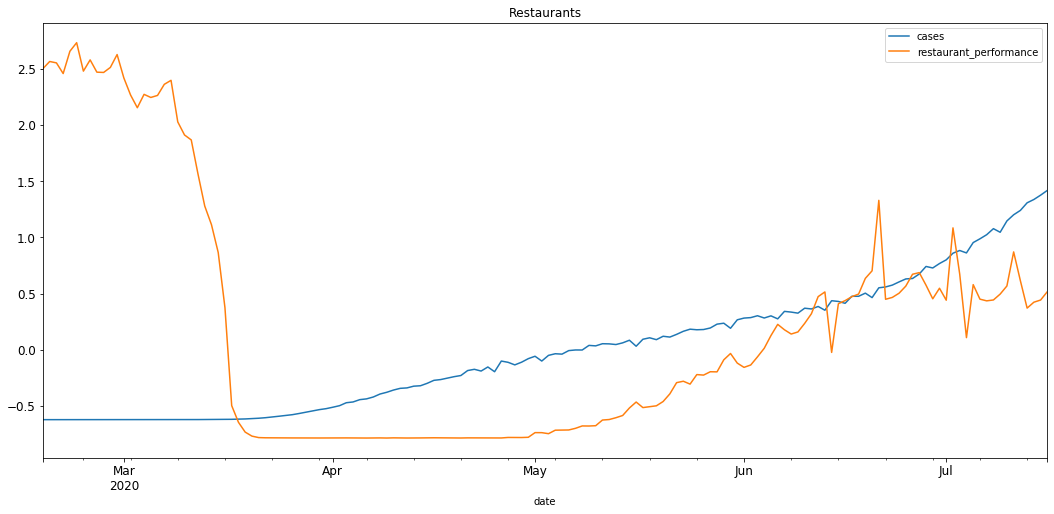

In [144]:
all_normalized.reset_index().plot(x='date', y=['cases', 'restaurant_performance'], figsize=(18,8), fontsize=12, title="Restaurants")

# ALL DATA BY STATE

In [168]:
# Create new dataframe from the percent change in mobility in each area and group by state
change = all_data_new.sort_index(level=['state', 'date'])

change['diff_cases'] = (change.groupby('state')['cases'].apply(pd.Series.diff))

#drop Nan values
change = change.replace([np.inf, -np.inf], np.nan)
change = change.dropna()

change['retail_recreation'] = change['retail_recreation'].astype(int)
change['grocery_pharmacy'] = change['grocery_pharmacy'].astype(int)
change['parks'] = change['parks'].astype(int)
change['transit'] = change['transit'].astype(int)
change['workplaces'] = change['workplaces'].astype(int)
change['residential'] = change['residential'].astype(int)

state = change.groupby(['state']).mean()

state = state.sort_values(['diff_cases'])
state

,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,cases,deaths,restaurant_performance,diff_cases
state,,,,,,,,,,
Hawaii,-42.873194,-24.012841,-48.544141,-62.850722,-35.669342,14.353130,570.823435,12.234350,-89.701862,2.069021
Oregon,-18.778523,0.019016,52.374161,-19.865772,-30.789150,9.282998,3587.252237,105.380313,-78.383003,3.012304
Ohio,-22.877907,-1.783140,82.291860,-15.715698,-34.421512,11.952326,22855.251744,1249.024419,-80.326663,5.293023
Maryland,-28.180106,-11.415976,55.492087,-35.910324,-40.069329,16.161266,29851.776187,1401.413715,-85.225373,5.795780
New Mexico,-21.721267,3.760181,11.880543,-23.827149,-33.116742,11.748416,5840.619910,239.247059,-83.539041,14.600905
Kentucky,-21.907916,2.478191,53.371567,-20.684976,-34.137318,11.631664,6543.242326,270.707593,-77.319176,15.649435
Washington,-18.539683,-0.313390,55.819699,-17.628409,-30.645910,9.746032,14826.532357,670.285307,-76.705824,18.830688
California,-30.114652,-4.702154,6.371017,-28.129785,-31.246573,11.831049,85946.339683,2590.717821,-74.275403,19.055724
Georgia,-18.167444,-1.070369,18.211106,-23.735481,-31.937685,11.156422,34199.852904,1309.053412,-75.326944,20.465451


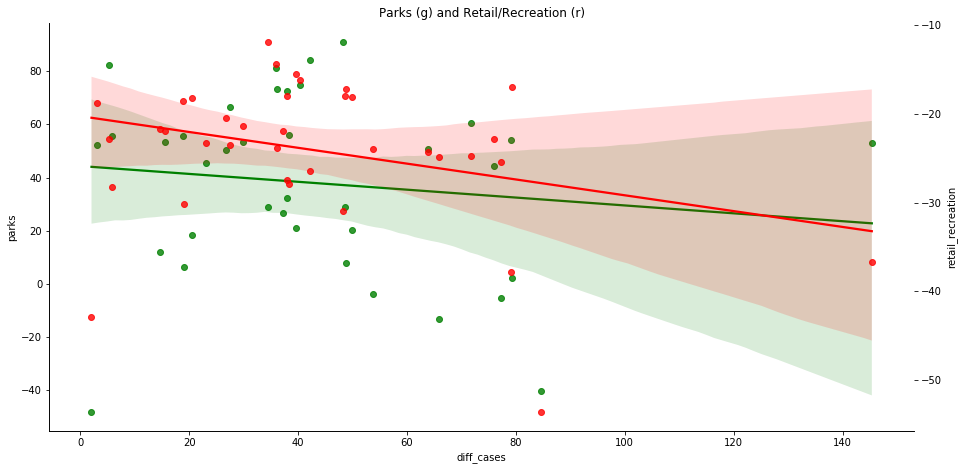

In [177]:
# Plot the relationship between number of cases and parks and retail/recreation mobility
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)
sns.regplot(state['diff_cases'], state['parks'], ax=ax, color='g')
ax2 = ax.twinx()
sns.regplot(state['diff_cases'], state['retail_recreation'], ax=ax2, color='r').set_title('Parks (g) and Retail/Recreation (r)')
sns.despine()

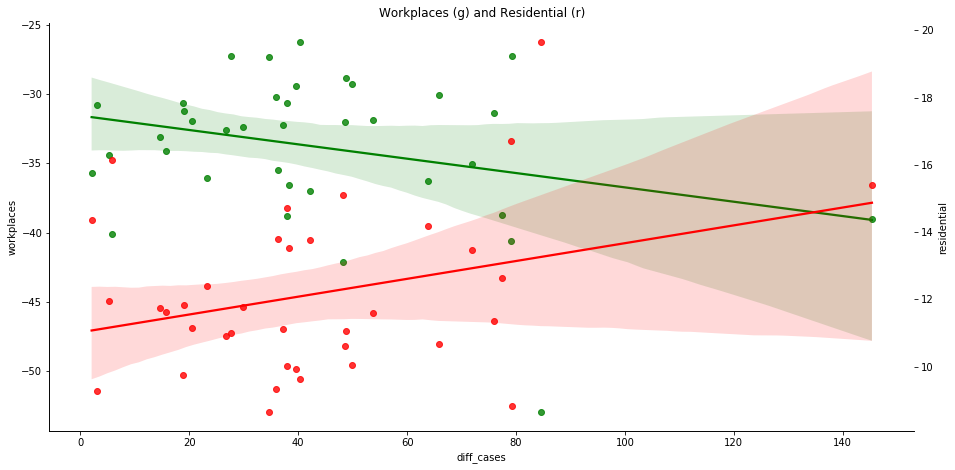

In [174]:
# Plot the relationship between number of cases and workplaces and residential mobility
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)
sns.regplot(state['diff_cases'], state['workplaces'], ax=ax, color='g')
ax2 = ax.twinx()
sns.regplot(state['diff_cases'], state['residential'], ax=ax2, color='r').set_title('Workplaces (g) and Residential (r)')
sns.despine()

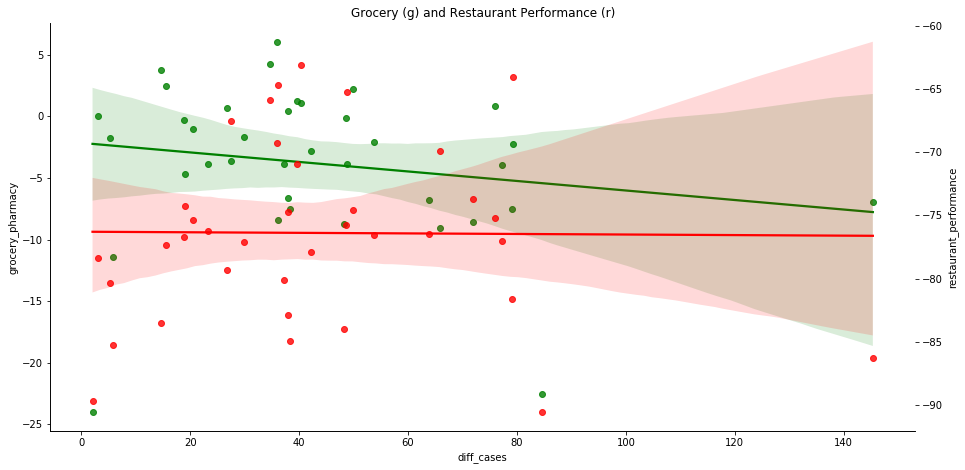

In [173]:
# Plot the relationship between number of cases and parks and retail/recreation mobility
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)
sns.regplot(state['diff_cases'], state['grocery_pharmacy'], ax=ax, color='g')
ax2 = ax.twinx()
sns.regplot(state['diff_cases'], state['restaurant_performance'], ax=ax2, color='r').set_title('Grocery (g) and Restaurant Performance (r)')
sns.despine()

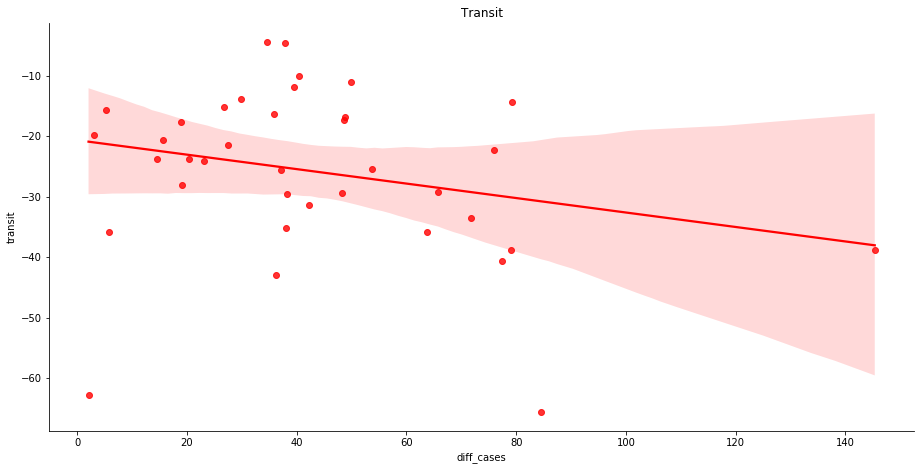

In [178]:
# Plot the relationship between number of cases and parks and retail/recreation mobility
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)
sns.regplot(state['diff_cases'], state['transit'], ax=ax, color='r').set_title('Transit')
sns.despine()

In [186]:
# Create new dataframe from the percent change in mobility in each area and group by state
change = all_data_new.sort_index(level=['state', 'date'])

change['retail_recreation'] = change['retail_recreation'].astype(int)
change['grocery_pharmacy'] = change['grocery_pharmacy'].astype(int)
change['parks'] = change['parks'].astype(int)
change['transit'] = change['transit'].astype(int)
change['workplaces'] = change['workplaces'].astype(int)
change['residential'] = change['residential'].astype(int)

change['pct_ch_rec'] = (change.groupby('state')['retail_recreation'].apply(pd.Series.pct_change))
change['pct_ch_groc'] = (change.groupby('state')['grocery_pharmacy'].apply(pd.Series.pct_change))
change['pct_ch_parks'] = (change.groupby('state')['parks'].apply(pd.Series.pct_change))
change['pct_ch_transit'] = (change.groupby('state')['transit'].apply(pd.Series.pct_change))
change['pct_ch_work'] = (change.groupby('state')['workplaces'].apply(pd.Series.pct_change))
change['pct_ch_residential'] = (change.groupby('state')['residential'].apply(pd.Series.pct_change))
change['pct_ch_rest'] = (change.groupby('state')['restaurant_performance'].apply(pd.Series.pct_change))
change['pct_ch_cases'] = (change.groupby('state')['cases'].apply(pd.Series.pct_change))

#drop Nan values
change = change.replace([np.inf, -np.inf], np.nan)
change = change.dropna()

date_norm = change.groupby(['state']).mean()

date_norm = date_norm.drop(['cases', 'deaths', 'restaurant_performance'], axis=1)

date_norm  = date_norm.sort_values(['pct_ch_cases'])

date_norm

,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,pct_ch_rec,pct_ch_groc,pct_ch_parks,pct_ch_transit,pct_ch_work,pct_ch_residential,pct_ch_rest,pct_ch_cases
state,,,,,,,,,,,,,,
Hawaii,-44.704698,-25.177852,-50.645973,-65.474832,-37.226510,14.939597,0.026988,0.021928,0.083062,-0.017066,0.036004,0.051371,0.013248,0.059770
Nebraska,-17.221983,0.948276,76.000000,-10.668103,-27.187500,10.043103,0.051440,-0.556621,-0.314446,-0.072658,0.150598,0.165422,-0.997131,0.061216
District of Columbia,-56.232000,-23.976000,-42.888000,-68.576000,-55.288000,20.520000,0.017368,0.050826,0.379566,0.015694,0.089796,0.131546,0.006701,0.062463
Washington,-21.140640,-1.086548,55.890405,-20.158984,-33.262935,10.661336,0.066174,-0.100887,0.018952,-0.069646,0.049865,0.108239,-0.057221,0.073166
California,-33.299716,-5.801539,4.678007,-30.963345,-34.252936,12.993520,0.035102,-0.016961,-0.111067,-0.070416,0.092427,0.065998,-0.004513,0.075016
Oregon,-20.685232,-0.763454,51.556320,-21.642053,-32.601377,9.915519,-0.007035,-0.034746,-0.218499,0.041860,0.046955,0.072464,-0.003289,0.079353
Arizona,-19.381842,-3.365154,0.674232,-16.696262,-29.636182,9.669559,-0.047921,0.032567,-0.016095,-0.018347,0.020597,0.034813,-0.001663,0.087618
Illinois,-25.809444,-0.442778,45.417222,-25.152222,-34.585556,12.575556,0.062539,-0.263144,-0.423309,-0.050025,0.104387,0.182478,-0.132608,0.087911
Massachusetts,-28.021818,-10.055273,63.253091,-37.320727,-38.502545,14.832727,0.016400,-0.069911,-0.483409,-0.129892,0.096577,0.136586,-0.236972,0.100208
